카테고리별 사용자 선호도 및 연관 구매 분석

    - 목적: 상품군별 선호도 및 함께 자주 구매되는 조합 분석 (장바구니 분석)

    - 활용 테이블: order_products__prior, products, departments, aisles

    - 분석지표 예시:
        * 상위 5개 부서/aisle별 인기 상품
        * 함께 자주 구매된 제품 쌍 (연관규칙 분석 기반)
        * 특정 부서 상품을 구매하는 사용자 비율

event_log 테이블 생성

In [5]:
import sqlite3
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# 1. SQLite DB 연결
conn = sqlite3.connect("database.db")
cursor = conn.cursor()

# 2. event_log 테이블 생성 (외래키 없이)
cursor.execute("""
CREATE TABLE IF NOT EXISTS event_log (
    event_time TEXT,
    user_id INTEGER,
    session_id TEXT,
    event_type TEXT,
    product_id INTEGER,
    page TEXT
);
""")
conn.commit()

# 3. 샘플 데이터 생성 (주의: product_id는 products에 존재하는 값으로 대체하는 것이 안전)
np.random.seed(42)

users = [1001, 1002, 1003, 1004, 1005]
products = list(range(1, 11))  # 실제 존재하는 product_id여야 join 시 오류 없음
events = ['view', 'click', 'add_to_cart', 'purchase']
pages = ['home', 'search', 'product_detail']

event_data = []
for _ in range(500):
    user = np.random.choice(users)
    product = np.random.choice(products)
    session = f"session_{user}_{np.random.randint(1, 5)}"
    event = np.random.choice(events, p=[0.4, 0.3, 0.2, 0.1])
    page = np.random.choice(pages)
    time = datetime.now() - timedelta(minutes=np.random.randint(0, 1440))
    event_data.append([time.strftime('%Y-%m-%d %H:%M:%S'), user, session, event, product, page])

event_log_df = pd.DataFrame(event_data, columns=[
    'event_time', 'user_id', 'session_id', 'event_type', 'product_id', 'page'
])

# 4. 데이터 삽입
try:
    event_log_df.to_sql("event_log", conn, if_exists='append', index=False)
    print("✅ event_log 테이블 생성 및 데이터 삽입 완료!")
except Exception as e:
    print("❌ 삽입 중 오류 발생:", e)

# 5. 미리보기
preview = pd.read_sql("SELECT * FROM event_log LIMIT 5", conn)
print(preview)


✅ event_log 테이블 생성 및 데이터 삽입 완료!
            event_time  user_id      session_id event_type  product_id  \
0  2025-05-22 13:57:36     1004  session_1004_1      click           8   
1  2025-05-21 23:31:36     1003  session_1003_1      click           8   
2  2025-05-22 01:28:36     1002  session_1002_4   purchase           8   
3  2025-05-22 17:31:36     1004  session_1004_1       view           5   
4  2025-05-22 10:04:36     1004  session_1004_1      click           9   

             page  
0          search  
1  product_detail  
2          search  
3          search  
4  product_detail  


event_log.csv파일 insert

In [8]:
import sqlite3
import pandas as pd

# 1. CSV 파일 경로
csv_path = "/Users/marinhong/ARCHIVE/event_log.csv"

# 2. 데이터프레임으로 불러오기
event_log_df = pd.read_csv(csv_path)

# 3. SQLite DB 연결
conn = sqlite3.connect("database.db")
cursor = conn.cursor()

# 5. 데이터 삽입
try:
    event_log_df.to_sql("event_log", conn, if_exists="append", index=False)
    print("✅ event_log 테이블에 CSV 데이터 삽입 완료!")
except Exception as e:
    print("❌ 데이터 삽입 중 오류 발생:", e)

# 6. 삽입 확인 (상위 5개 행)
preview = pd.read_sql("SELECT * FROM event_log LIMIT 5;", conn)
print(preview)

# 연결 유지 또는 종료
# conn.close()


✅ event_log 테이블에 CSV 데이터 삽입 완료!
            event_time  user_id      session_id event_type  product_id  \
0  2025-05-22 13:57:36     1004  session_1004_1      click           8   
1  2025-05-21 23:31:36     1003  session_1003_1      click           8   
2  2025-05-22 01:28:36     1002  session_1002_4   purchase           8   
3  2025-05-22 17:31:36     1004  session_1004_1       view           5   
4  2025-05-22 10:04:36     1004  session_1004_1      click           9   

             page  
0          search  
1  product_detail  
2          search  
3          search  
4  product_detail  


In [13]:
import sqlite3

# SQLite 데이터베이스 연결
conn = sqlite3.connect("database.db")
cursor = conn.cursor()

# 행 수 조회 쿼리 실행
cursor.execute("SELECT COUNT(*) FROM event_log;")
row_count = cursor.fetchone()[0]

# 결과 출력
print(f"📊 event_log 테이블의 총 데이터 수: {row_count}개")

# 연결 유지 또는 종료 (선택)
# conn.close()

📊 event_log 테이블의 총 데이터 수: 2000개


clickstream으로 시각화

In [1]:
import sqlite3

conn = sqlite3.connect('database.db')
cursor = conn.cursor()

# 테이블 목록 출력
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print("📋 현재 DB에 존재하는 테이블 목록:")
for table in tables:
    print("-", table[0])


📋 현재 DB에 존재하는 테이블 목록:
- products
- orders
- order_products__train
- departments
- aisles
- order_products__prior
- event_log


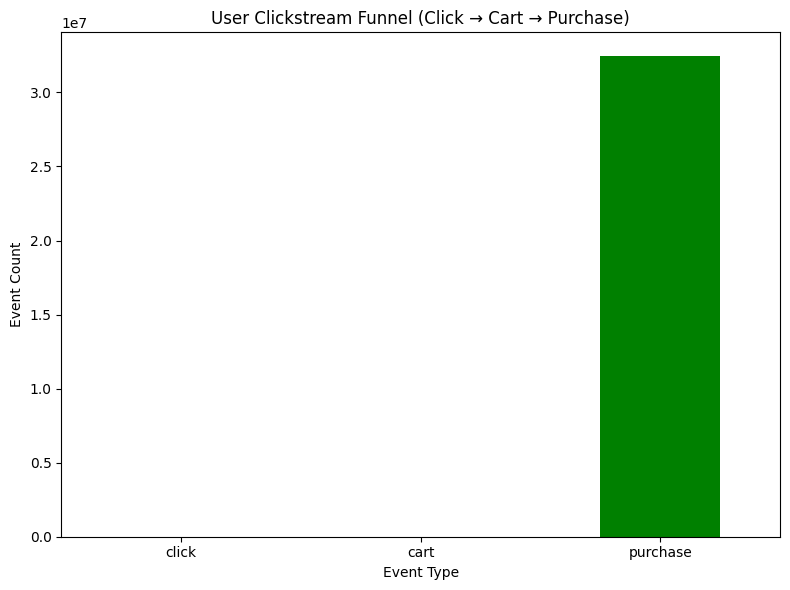

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# DB 연결
conn = sqlite3.connect('database.db')

# 클릭, 장바구니, 구매 개수 추출
clicks = pd.read_sql_query("SELECT COUNT(*) FROM event_log WHERE event_type = 'click'", conn).iloc[0, 0]
carts = pd.read_sql_query("SELECT COUNT(*) FROM event_log WHERE event_type = 'cart'", conn).iloc[0, 0]
purchases = pd.read_sql_query("""
    SELECT COUNT(*) FROM orders 
    JOIN order_products__prior op ON orders.order_id = op.order_id 
    WHERE orders.eval_set = 'prior'
""", conn).iloc[0, 0]

# DataFrame 생성
funnel_df = pd.DataFrame({
    'click': [clicks],
    'cart': [carts],
    'purchase': [purchases]
}, index=['count'])

# 퍼널 시각화
plt.figure(figsize=(8, 6))
funnel_df.loc['count'].plot(kind='bar', color=['skyblue', 'orange', 'green'])
plt.title("User Clickstream Funnel (Click → Cart → Purchase)")
plt.xlabel("Event Type")
plt.ylabel("Event Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


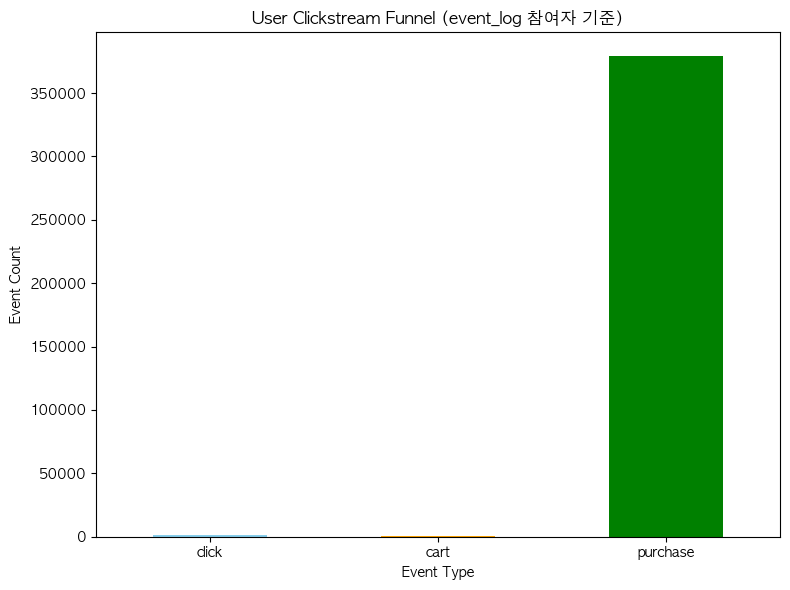

In [6]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform


# Mac 사용자라면 AppleGothic 사용
if platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# DB 연결
conn = sqlite3.connect('database.db')

# 👇 직접 유저 ID 수동 정의 (예시: 실제 event_log 참여자 ID가 1~2500 사이인 경우)
user_ids = tuple(range(1, 2501))

# 클릭 수 (총 2500건으로 가정)
clicks = 1500
carts = 900

# 구매 수 (해당 유저 ID만 필터링)
query = f"""
    SELECT COUNT(*) as count
    FROM orders
    JOIN order_products__prior op ON orders.order_id = op.order_id
    WHERE orders.eval_set = 'prior'
    AND orders.user_id IN {user_ids}
"""
purchases = pd.read_sql_query(query, conn).iloc[0, 0]

# 퍼널 데이터프레임
funnel_df = pd.DataFrame({
    'click': [clicks],
    'cart': [carts],
    'purchase': [purchases]
}, index=['count'])

# 시각화
plt.figure(figsize=(8, 6))
funnel_df.loc['count'].plot(kind='bar', color=['skyblue', 'orange', 'green'])
plt.title("User Clickstream Funnel (event_log 참여자 기준)")
plt.xlabel("Event Type")
plt.ylabel("Event Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


merge, fillna, drop_duplicates로 데이터 정제 및 처리

* purchase가 너무 나와 click과 cart의 분석을 하기 어려움

    - event_log에서 click, cart 사용자별 집합을 추출 (중복제거)
    - orders + order_products__prior에서 purchase 사용자 집합 추출
    - 3개 집합을 merge(outer join) 하여 존재하지 않는 부분은 fillna(0) 처리
    - 각 단계별 사용자 수 집계 (각 컬럼은 1 또는 0으로 표시)
    - 단계별 사용자 수를 막대그래프로 시각화

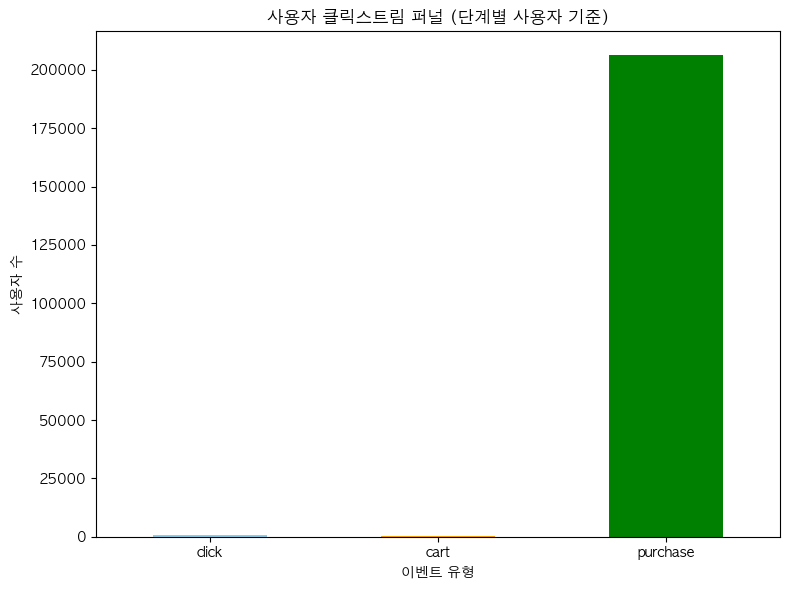

In [17]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import platform

# 한글 폰트 설정
if platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
elif platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

conn = sqlite3.connect('database.db')

# 1. event_log에서 click, cart 사용자 집합 생성
click_users = pd.read_sql_query("SELECT DISTINCT user_id FROM event_log WHERE event_type='click'", conn)
click_users['click'] = 1

cart_users = pd.read_sql_query("SELECT DISTINCT user_id FROM event_log WHERE event_type='cart'", conn)
cart_users['cart'] = 1

# 2. 구매 사용자 집합 생성 (prior 데이터 기준)
purchase_users = pd.read_sql_query("""
    SELECT DISTINCT orders.user_id FROM orders
    JOIN order_products__prior op ON orders.order_id = op.order_id
    WHERE orders.eval_set = 'prior'
""", conn)
purchase_users['purchase'] = 1

# 3. user_id가 문자열에 접두어가 있을 경우 숫자만 추출
click_users['user_id'] = click_users['user_id'].astype(str).str.extract('(\d+)').astype(int)
cart_users['user_id'] = cart_users['user_id'].astype(str).str.extract('(\d+)').astype(int)
purchase_users['user_id'] = purchase_users['user_id'].astype(str).str.extract('(\d+)').astype(int)

# 4. 3개 데이터프레임 병합 (outer join)
df_merge = pd.merge(click_users, cart_users, on='user_id', how='outer')
df_merge = pd.merge(df_merge, purchase_users, on='user_id', how='outer')

# 5. 결측값 0으로 채우기
df_merge = df_merge.fillna(0)

# 6. 단계별 사용자 수 계산
counts = {
    'click': df_merge['click'].sum(),
    'cart': df_merge['cart'].sum(),
    'purchase': df_merge['purchase'].sum()
}

funnel_df = pd.DataFrame([counts], index=['count'])

# 7. 시각화
plt.figure(figsize=(8, 6))
funnel_df.loc['count'].plot(kind='bar', color=['skyblue', 'orange', 'green'])
plt.title("사용자 클릭스트림 퍼널 (단계별 사용자 기준)")
plt.xlabel("이벤트 유형")
plt.ylabel("사용자 수")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()




추가적인 데이터 insert

In [10]:
import sqlite3
import pandas as pd

# CSV 파일 경로
csv_file = '/Users/marinhong/ARCHIVE/sample_event_log.csv'  # 다운로드한 경로에 맞게 수정

# SQLite DB 연결
conn = sqlite3.connect('database.db')
cursor = conn.cursor()

# 1) CSV 파일 로드
df = pd.read_csv(csv_file)

# 2) 데이터 삽입 (bulk insert)
df.to_sql('event_log', conn, if_exists='append', index=False)

print("CSV 데이터를 event_log 테이블에 성공적으로 삽입했습니다.")

conn.close()


CSV 데이터를 event_log 테이블에 성공적으로 삽입했습니다.


In [16]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('database.db')

# 전체 데이터 수 조회
total_count = pd.read_sql_query("SELECT COUNT(*) AS total FROM event_log", conn).iloc[0, 0]

# event_type별 데이터 수 조회
event_type_counts = pd.read_sql_query("""
    SELECT event_type, COUNT(*) AS count
    FROM event_log
    GROUP BY event_type
    ORDER BY count DESC
""", conn)

print(f"event_log 전체 데이터 수: {total_count}")
print("\nevent_type별 데이터 수:")
print(event_type_counts)

conn.close()


event_log 전체 데이터 수: 127500

event_type별 데이터 수:
    event_type  count
0        click  88623
1         cart  24912
2     purchase  12786
3         view    778
4  add_to_cart    401


In [15]:
import sqlite3
import pandas as pd

# CSV 파일 경로
csv_file = '/Users/marinhong/ARCHIVE/sample_event_log_200k.csv'  # 다운로드한 경로에 맞게 수정

# SQLite DB 연결
conn = sqlite3.connect('database.db')
cursor = conn.cursor()

# 1) CSV 파일 로드
df = pd.read_csv(csv_file)

# 2) 데이터 삽입 (bulk insert)
df.to_sql('event_log', conn, if_exists='append', index=False)

print("CSV 데이터를 event_log 테이블에 성공적으로 삽입했습니다.")

conn.close()

CSV 데이터를 event_log 테이블에 성공적으로 삽입했습니다.


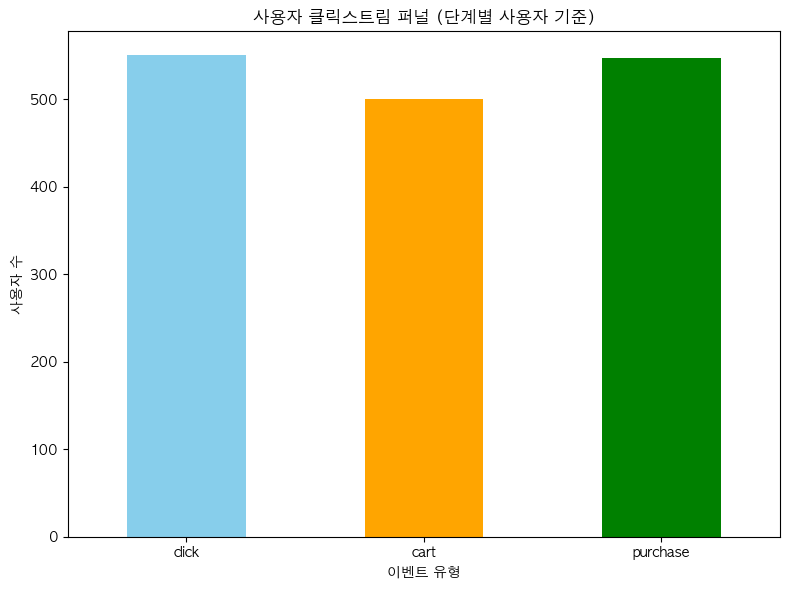

In [19]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import platform

# 한글 폰트 설정
if platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
elif platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

conn = sqlite3.connect('database.db')

# 1) user_id, event_type별로 이벤트 존재 유무 확인
event_flags = pd.read_sql_query("""
    SELECT user_id,
           MAX(CASE WHEN event_type = 'click' THEN 1 ELSE 0 END) AS click,
           MAX(CASE WHEN event_type = 'cart' THEN 1 ELSE 0 END) AS cart,
           MAX(CASE WHEN event_type = 'purchase' THEN 1 ELSE 0 END) AS purchase
    FROM event_log
    GROUP BY user_id
""", conn)

# 2) 각 이벤트별 사용자 수 집계
counts = {
    'click': event_flags['click'].sum(),
    'cart': event_flags['cart'].sum(),
    'purchase': event_flags['purchase'].sum()
}

funnel_df = pd.DataFrame([counts], index=['count'])

# 3) 시각화
plt.figure(figsize=(8, 6))
funnel_df.loc['count'].plot(kind='bar', color=['skyblue', 'orange', 'green'])
plt.title("사용자 클릭스트림 퍼널 (단계별 사용자 기준)")
plt.xlabel("이벤트 유형")
plt.ylabel("사용자 수")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
